In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, confusion_matrix, classification_report, precision_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('./data/data_eda.csv')
df

,Unnamed: 0,annual_income,birthday,days_employment,family_size,work_phone,phone,email,car,property,...,occupation_Realty agents,occupation_Private service staff,marital_Single / not married,marital_Married,marital_Civil marriage,marital_Separated,marital_Widow,label,ID,window
0,0,427500.0,-12005,-4542,2.0,1,0,0,1.0,1.0,...,0,0,0,0,1,0,0,0.0,5008804,15.0
1,1,427500.0,-12005,-4542,2.0,1,0,0,1.0,1.0,...,0,0,0,0,1,0,0,0.0,5008805,14.0
2,2,112500.0,-21474,-1134,2.0,0,0,0,1.0,1.0,...,0,0,0,1,0,0,0,0.0,5008806,29.0
3,3,270000.0,-19110,-3051,1.0,0,1,1,0.0,1.0,...,0,0,1,0,0,0,0,0.0,5008808,4.0
4,4,270000.0,-19110,-3051,1.0,0,1,1,0.0,1.0,...,0,0,1,0,0,0,0,0.0,5008809,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,438552,135000.0,-22717,365243,1.0,0,0,0,0.0,1.0,...,0,0,0,0,0,1,0,NaN,6840104,NaN
438553,438553,103500.0,-15939,-3007,1.0,0,0,0,0.0,0.0,...,0,0,1,0,0,0,0,NaN,6840222,NaN
438554,438554,54000.0,-8169,-372,1.0,1,0,0,0.0,0.0,...,0,0,1,0,0,0,0,NaN,6841878,NaN
438555,438555,72000.0,-21673,365243,2.0,0,0,0,0.0,1.0,...,0,0,0,1,0,0,0,NaN,6842765,NaN


In [3]:
df.dropna(inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
df

In [4]:
df.label.value_counts() # base rate = 1.7%

0.0    35841
1.0      616
Name: label, dtype: int64

**Just learning from the users who have long than 3 months of records.** 

In [5]:
df_3m = df.loc[df.window >= 3]

In [6]:
df_3m.label.value_counts() # base rate = 1.8%

0.0    33512
1.0      615
Name: label, dtype: int64

Text(0.5, 1.0, "Distribution of users' class")

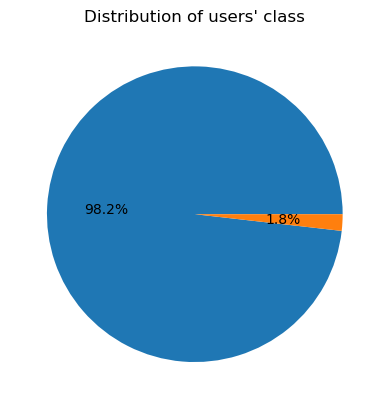

In [7]:
plt.pie(df_3m['label'].value_counts(), autopct='%1.1f%%')
plt.title('Distribution of users\' class')

**The old model predicted all the applicants in the dataset df_3m as 'good' client.**  
- We labeled the credit card users who overdue for more than 60 days as risk clients.
- The money loss predicted by the old model is: 0 
-The precision of our new model will represent how many 'bad' clients we can predict. The money loss can be predicted as: FN * loss_aver + FP * gain_aver, loss_aver is the average of money loss caused by a 'bad' client, gain_aver is the money gain brought by a 'good' client on average. 
-So how to evalute the model's performance depends on the money loss of one bad client and money gain of one good client. We can talk with other teams to discuss how to do feature engineering, select model and tune model.

In [ ]:
33512 / (33512+515)

# Scaling data and Processing imbalance dataset

**Oversample the minority class using SMOTE**

In [8]:
numeric_features = ['annual_income', 'birthday', 'days_employment', 'family_size']
scaler = ColumnTransformer(
    transformers=[('num_scaler', StandardScaler(), numeric_features)],
    remainder='passthrough'
)
#oversample = SMOTE(random_state=1) # sampling_strategy: can try to tune

# Model Selection

**Using repeated stratified Kfold to evaluate.**
- Both StratifiedKFold and RepeatedStratifiedKFold can be very effective when used on classification problems with a severe class imbalance. They both stratify the sampling by the class label; that is, they split the dataset in such a way that preserves approximately the same class distribution (i.e., the same percentage of samples of each class) in each subset/fold as in the original dataset. 
- However, a single run of StratifiedKFold might result in a noisy estimate of the model's performance, as different splits of the data might result in very different results. That is where RepeatedStratifiedKFold comes into play.

In [9]:
features = list(df_3m.columns)
target = 'label'
features.remove('ID')
features.remove('window')
features.remove(target)
features

['annual_income',
 'birthday',
 'days_employment',
 'family_size',
 'work_phone',
 'phone',
 'email',
 'car',
 'property',
 'education',
 'gender_M',
 'gender_F',
 'income_Student',
 'income_Student.1',
 'income_Pensioner',
 'income_Pensioner.1',
 'income_State servant',
 'income_State servant.1',
 'income_Commercial associate',
 'income_Commercial associate.1',
 'income_Working',
 'income_Working.1',
 'housing_Municipal apartment',
 'housing_With parents',
 'housing_Office apartment',
 'housing_Rented apartment',
 'housing_House / apartment',
 'housing_Co-op apartment',
 'occupation_Cleaning staff',
 'occupation_others',
 'occupation_Security staff',
 'occupation_Medicine staff',
 'occupation_Managers',
 'occupation_Sales staff',
 'occupation_Cooking staff',
 'occupation_Core staff',
 'occupation_Laborers',
 'occupation_Low-skill Laborers',
 'occupation_Waiters/barmen staff',
 'occupation_IT staff',
 'occupation_Accountants',
 'occupation_Secretaries',
 'occupation_High skill tech sta

In [10]:
X = df_3m[features]
y = df_3m[target]

## Using ROC_AUC as metric to choose models

**1. Logistic Regression**

In [11]:
# define pipeline
steps = [('over', SMOTE()), 
         ('scaler', scaler),
         ('model', LogisticRegression(tol=0.001, max_iter=10000, n_jobs=-1))]
pipeline = Pipeline(steps=steps)
Pipeline(steps=steps)

Pipeline(steps=[('over', SMOTE()),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_scaler',
                                                  StandardScaler(),
                                                  ['annual_income', 'birthday',
                                                   'days_employment',
                                                   'family_size'])])),
                ('model',
                 LogisticRegression(max_iter=10000, n_jobs=-1, tol=0.001))])

In [12]:
# evaluate pipeline
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

#scores = cross_validate(pipeline, X, y, scoring=('roc_auc', 'precision') , cv=cv, n_jobs=-1)
#print(scores)

Mean ROC AUC: 0.541


**2. SVM**

In [13]:
steps = [('over', SMOTE()), 
         ('scaler', scaler),
         ('model', SVC(kernel='rbf'))]
pipeline = Pipeline(steps=steps)
Pipeline(steps=steps)

Pipeline(steps=[('over', SMOTE()),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_scaler',
                                                  StandardScaler(),
                                                  ['annual_income', 'birthday',
                                                   'days_employment',
                                                   'family_size'])])),
                ('model', SVC())])

In [14]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.642


**3. Random Forest**

In [15]:
steps = [('over', SMOTE()), 
         ('scaler', scaler),
         ('model', RandomForestClassifier(min_samples_split=10, min_samples_leaf=5))]
pipeline = Pipeline(steps=steps)
Pipeline(steps=steps)

Pipeline(steps=[('over', SMOTE()),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_scaler',
                                                  StandardScaler(),
                                                  ['annual_income', 'birthday',
                                                   'days_employment',
                                                   'family_size'])])),
                ('model',
                 RandomForestClassifier(min_samples_leaf=5,
                                        min_samples_split=10))])

In [16]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.755


**4. XGBoost**

In [17]:
steps = [('over', SMOTE()), 
         ('scaler', scaler),
         ('model', XGBClassifier(learning_rate=1, objective='binary:logistic'))]
pipeline = Pipeline(steps=steps)
Pipeline(steps=steps)

Pipeline(steps=[('over', SMOTE()),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_scaler',
                                                  StandardScaler(),
                                                  ['annual_income', 'birthday',
                                                   'days_employment',
                                                   'family_size'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [18]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.755


# Tune model

**XGBoost**

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

In [ ]:
steps = [('over', SMOTE()), 
         ('scaler', scaler),
         ('model', XGBClassifier(objective='binary:logistic', 
                                 learning_rate=0.5, max_depth=8,
                                 n_estimators=250, min_child_weight=4))]
param = {#'model__learning_rate': [0.005, 0.05, 0.1, 0.5, 1],  # 0.5
         #'model__gamma': [0, 0.5, 1, 1.5, 2],  # 0
         #'model__max_depth': np.arange(3, 10),  # 8
         #'model__n_estimators': [100, 200, 250, 300, 400], # 250
         #'model__lambda': [1, 1.5, 2],
         #'model__subsample': [1, 0.8],
         'model__min_child_weight': np.arange(1, 10)  # 4
        }

scorer = make_scorer(precision_score)
model_tuned = GridSearchCV(
    estimator=Pipeline(steps),
    param_grid=param,
    scoring=scorer,
    n_jobs = -1,
    cv=3).fit(X_train, y_train)

print('Tunning results: ', model_tuned.best_params_)

In [ ]:
y_train_pred = model_tuned.best_estimator_.predict(X_train)
y_test_pred = model_tuned.best_estimator_.predict(X_test)
print('Classification metrics of Train data: \n', classification_report(y_train, y_train_pred))
print('Classification metrics of Test data: \n', classification_report(y_test, y_test_pred))
print('---------------------------------------')
print('Confusion matrix of Train data: \n', confusion_matrix(y_train, y_train_pred, labels=[1, 0]))
print('Confusion matrix of Test data: \n', confusion_matrix(y_test, y_test_pred, labels=[1, 0]))

**Test the tuned model**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) #, stratify=y)

steps = [('over', SMOTE()), 
         ('scaler', scaler),
         ('model', XGBClassifier(objective='binary:logistic', 
                                 learning_rate=0.5, max_depth=8,
                                 n_estimators=250, min_child_weight=4))]
'''

steps = [('over', SMOTE()), 
         ('scaler', scaler),
         ('model', XGBClassifier(objective='binary:logistic', 
                                 learning_rate=0.02, max_depth=12,
                                 n_estimators=250, min_child_weight=8,
                                 subsample=0.8))]
'''

model = Pipeline(steps).fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('Classification metrics of Train data: \n', classification_report(y_train, y_train_pred))
print('Classification metrics of Test data: \n', classification_report(y_test, y_test_pred))
print('---------------------------------------')
print('Confusion matrix of Train data: \n', confusion_matrix(y_train, y_train_pred, labels=[1, 0]))
print('Confusion matrix of Test data: \n', confusion_matrix(y_test, y_test_pred, labels=[1, 0]))

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred)).plot()
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred)).plot()

**Random Forest**

In [ ]:
steps = [('over', SMOTE()), 
         ('scaler', scaler),
         ('model', RandomForestClassifier())] #min_samples_split=15, min_samples_leaf=5)

param = {#'model__min_samples_split': np.arange(3, 20), # 15
         'model__min_samples_leaf': np.arange(5, 30), # 5
         'model__max_depth': np.arange(2, 10),  
         #'model__n_estimators': [100, 200, 250, 300, 400] 
        }

scorer = make_scorer(precision_score)
model_tuned = GridSearchCV(
    estimator=Pipeline(steps),
    param_grid=param,
    scoring=scorer,
    n_jobs = -1,
    cv=3).fit(X_train, y_train)

print('Tunning results: ', model_tuned.best_params_)

In [ ]:
y_train_pred = model_tuned.best_estimator_.predict(X_train)
y_test_pred = model_tuned.best_estimator_.predict(X_test)

print('Classification metrics of Train data: \n', classification_report(y_train, y_train_pred))
print('Classification metrics of Test data: \n', classification_report(y_test, y_test_pred))
print('---------------------------------------')
print('Confusion matrix of Train data: \n', confusion_matrix(y_train, y_train_pred, labels=[1, 0]))
print('Confusion matrix of Test data: \n', confusion_matrix(y_test, y_test_pred, labels=[1, 0]))